In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

In [2]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

train_path = 'C:/Users/ohike/Desktop/Dacon/Satelite Precipitation/train'
test_path = 'C:/Users/ohike/Desktop/Dacon/Satelite Precipitation/test'

In [3]:
data_sample = np.load('C:/Users/ohike/Desktop/Dacon/Satelite Precipitation/train/subset_010462_01.npy')
type(data_sample), data_sample.shape
data_sample.tofile('sample.txt', sep=" ", format="%s")


- 밝기 온도 채널만 사용해보기 위해 0~8 채널만 불러오기
- 약 7만장의 전체 데이터를 사용하지 않고, 50개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용해보기


In [4]:
def trainGenerator():
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        dataset = np.load(file)
        
        target = dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target<0, 0, target)
        feature = dataset[:,:,:9]
        
        if (cutoff_labels > 0).sum() < 10: #여기 50에서 10으로 수정
            continue
        yield(feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32),(tf.TensorShape([40, 40, 9]), tf.TensorShape([40,40,1])))

In [5]:
train_dataset

<FlatMapDataset shapes: ((40, 40, 9), (40, 40, 1)), types: (tf.float32, tf.float32)>

In [6]:
train_dataset = train_dataset.batch(512).prefetch(1)

In [7]:
test_files = sorted(glob.glob(test_path + '/*'))

X_test = []

for file in tqdm(test_files, desc='test'):
    data = np.load(file)
    X_test.append(data[:,:,:9])

X_test = np.array(X_test)

test: 100%|███████████████████████████████████████████████████████████████████████| 2416/2416 [00:22<00:00, 108.23it/s]


In [8]:
X_test

array([[[[187.87782288, 117.11814117, 227.91667175, ..., 222.88275146,
          283.04528809, 279.37545776],
         [184.36054993, 113.44564819, 221.50495911, ..., 212.55929565,
          284.53024292, 279.58337402],
         [180.92469788, 107.85658264, 216.58122253, ..., 194.60279846,
          283.69876099, 275.11367798],
         ...,
         [177.75027466, 101.63505554, 212.99153137, ..., 187.08912659,
          273.50427246, 264.64123535],
         [176.24658203,  99.89099121, 212.61325073, ..., 183.10041809,
          279.71298218, 270.21444702],
         [174.85987854,  98.25533295, 211.55839539, ..., 181.936203  ,
          279.93374634, 270.81756592]],

        [[181.2550354 , 110.12375641, 220.56573486, ..., 207.65327454,
          282.16009521, 273.94586182],
         [180.89909363, 109.3894577 , 219.12832642, ..., 200.63220215,
          282.29168701, 273.86120605],
         [181.58903503, 108.27979279, 221.62719727, ..., 209.81231689,
          279.4347229 , 275.75613

In [9]:
import seaborn as sns

In [10]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [11]:
image_sample = np.load('train/subset_010462_02.npy')

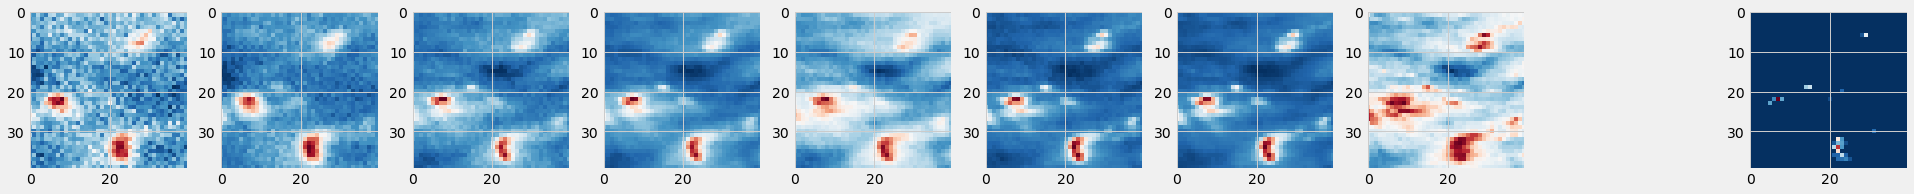

In [12]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30,30))

for i in range(8):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:,:,i], cmap=color_map)
    
plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap=color_map)
plt.show()

In [13]:
#모델구축단계

def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    #pool1 = Dropout(0.25)(pool1) #드랍아웃기능을 사용하지않는다

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    #pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    #uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    #uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    #uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [14]:
model = Model(input_layer, output_layer)

In [15]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #옵티마이저 별도지정
model.compile(loss="mae", optimizer=opt, metrics=[maeOverFscore_keras, fscore_keras])

In [17]:
#모델 학습 및 검증 단계
model_history = model.fit(train_dataset, epochs = 2, verbose=1) #steps_per_epoch 파라미터 설정

Epoch 1/2
93/93 [==============================] 0.5667 - maeOverFscore_keras: 7.6226 - fscore_keras: 0.21 - 47s 24s/step - loss: 0.5631 - maeOverFscore_keras: 8.0699 - fscore_keras: 0.18 - 62s 21s/step - loss: 0.4859 - maeOverFscore_keras: 8.1858 - fscore_keras: 0.18 - 78s 19s/step - loss: 0.4225 - maeOverFscore_keras: 7.4853 - fscore_keras: 0.19 - 94s 19s/step - loss: 0.3824 - maeOverFscore_keras: 7.3622 - fscore_keras: 0.19 - 121s 20s/step - loss: 0.3623 - maeOverFscore_keras: 7.1392 - fscore_keras: 0.210 - 138s 20s/step - loss: 0.3436 - maeOverFscore_keras: 6.9590 - fscore_keras: 0.221 - 154s 19s/step - loss: 0.3347 - maeOverFscore_keras: 7.0318 - fscore_keras: 0.227 - 169s 19s/step - loss: 0.3226 - maeOverFscore_keras: 6.8813 - fscore_keras: 0.239 - 184s 18s/step - loss: 0.3157 - maeOverFscore_keras: 6.6900 - fscore_keras: 0.253 - 199s 18s/step - loss: 0.3090 - maeOverFscore_keras: 6.5736 - fscore_keras: 0.262 - 216s 18s/step - loss: 0.3058 - maeOverFscore_keras: 6.5914 - fscore_k

93/93 [==============================] - ETA: 43:25 - loss: 0.1137 - maeOverFscore_keras: 2.8232 - fscore_keras: 0.475 - ETA: 37:26 - loss: 0.1173 - maeOverFscore_keras: 2.7215 - fscore_keras: 0.472 - ETA: 34:12 - loss: 0.1212 - maeOverFscore_keras: 2.6361 - fscore_keras: 0.492 - ETA: 33:16 - loss: 0.1170 - maeOverFscore_keras: 2.5155 - fscore_keras: 0.496 - ETA: 35:29 - loss: 0.1140 - maeOverFscore_keras: 2.4641 - fscore_keras: 0.496 - ETA: 35:47 - loss: 0.1176 - maeOverFscore_keras: 2.3981 - fscore_keras: 0.518 - ETA: 34:31 - loss: 0.1203 - maeOverFscore_keras: 2.4281 - fscore_keras: 0.520 - ETA: 33:44 - loss: 0.1288 - maeOverFscore_keras: 2.5518 - fscore_keras: 0.520 - ETA: 32:41 - loss: 0.1318 - maeOverFscore_keras: 2.5612 - fscore_keras: 0.527 - ETA: 31:37 - loss: 0.1377 - maeOverFscore_keras: 2.5595 - fscore_keras: 0.536 - ETA: 30:43 - loss: 0.1418 - maeOverFscore_keras: 2.5547 - fscore_keras: 0.545 - ETA: 29:35 - loss: 0.1475 - maeOverFscore_keras: 2.5807 - fscore_keras: 0.552 -

In [18]:
#모델 저장
model.save('C:/Users/ohike/Desktop/Dacon/Satelite Precipitation/model_baseline.h5')

In [19]:
pred = model.predict(X_test)

In [20]:
pred

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [21]:
submission = pd.read_csv('C:/Users/ohike/Desktop/Dacon/Satelite Precipitation/sample_submission.csv')

In [22]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [23]:
submission.to_csv('C:/Users/ohike/Desktop/Dacon/Satelite Precipitation/submission_baseline.csv', index = False)

# Research Note